# JuliaによるtidyなData Handling

----
## はじめに  

こんにちは。これは[Julia Advent Calender 2019](https://qiita.com/advent-calendar/2019/julialang)の2日目の記事です。  
はじめまして[takuizum](https://twitter.com/takuizum)です。たぶん「たくいずむ」って読みます。


この記事では，プログラミング言語Rで超有名なパッケージ`tidyr`&`dplyr`と同様の処理を行う関数がJuliaにもあるのですが，それを少しまとめてみます。

パッケージのマニュアルは[こちら](https://juliadata.github.io/DataFrames.jl/stable/)

今回扱う内容は`DataFrames`と`DataFramesMeta`です。ほかにも`Query`なんかでもデータフレームが操作できます。

----
## DataFrameとは

juliaやR， pythonには行列や配列とは異なる形式としてDataFrame (データフレーム) と呼ばれるデータ形式が存在します。データフレームは名前付き行列や配列と似たような形です。配列と異なる点は，明示的に型を変換しなくても，複数の異なる型の列を保持できる点です。また多くのデータフレームでは行よりも，列の要素に特殊な意味やまとまりがあります。

もちろんUnionやAnyなどの型を利用すれば，複数の異なる型の要素を維持した配列を作ることはできるますが，列ごとに意味を持ったまとまりをもつような表現形式（たとえば観察データを集計したデータテーブル）では列ごとに型を管理できるデータフレームのほうが都合が良いです。

In [44]:
using DataFrames, Random;

In [47]:
df = DataFrame(A = 1:4, B = ["M", "F", "F", "M"], C = randn(4))

4×3 DataFrame
│ Row │ A     │ B      │ C          │
│     │ Int64 │ String │ Float64    │
├─────┼───────┼────────┼────────────┤
│ 1   │ 1     │ M      │ 0.817975   │
│ 2   │ 2     │ F      │ 1.04664    │
│ 3   │ 3     │ F      │ -0.142099  │
│ 4   │ 4     │ M      │ -0.0587445 │

In [48]:
mat = [1 "M"; 2 "M"]

2×2 Array{Any,2}:
 1  "M"
 2  "M"

----
# 基本操作
## 列名の取り出し

データフレームにアクセスするときは`Symbols`を使い，`df[:col]`, `df[:, :A]`, `df.A` という3つの方法で列の要素を取り出すことができます。

In [49]:
df[:A] == df[:, :A] == df.A

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[49]:1
└ @ Core In[49]:1


true

## データフレームの要約

`describe`関数で一発です。Floatに対しては平均や中央値などの基礎統計料を，Categoricalに対してはユニークな要素の数を表示してくれます。

In [7]:
df = DataFrame(Int = [1:1:10;], 
               Float = [1.:1.:10.;],
               Categorical = CategoricalArray(["A","B","C","A","B","C","A","B","C","D"]), 
               String = ["A","B","C","A","B","C","A","B","C","D"])
describe(df)

4×8 DataFrame. Omitted printing of 1 columns
│ Row │ variable    │ mean   │ min │ median │ max  │ nunique │ nmissing │
│     │ Symbol      │ Union… │ Any │ Union… │ Any  │ Union…  │ Nothing  │
├─────┼─────────────┼────────┼─────┼────────┼──────┼─────────┼──────────┤
│ 1   │ Int         │ 5.5    │ 1   │ 5.5    │ 10   │         │          │
│ 2   │ Float       │ 5.5    │ 1.0 │ 5.5    │ 10.0 │         │          │
│ 3   │ Categorical │        │ A   │        │ D    │ 4       │          │
│ 4   │ String      │        │ A   │        │ D    │ 4       │          │

そのほかにも，標準偏差や四分位数も出してくれます。また，任意の関数も使えます。

In [8]:
using RDatasets
iris = RDatasets.dataset("datasets", "iris")
describe(iris, :std, :q25, :q75, :sum => sum)

5×5 DataFrame
│ Row │ variable    │ std      │ q25    │ q75    │ sum    │
│     │ Symbol      │ Union…   │ Union… │ Union… │ Union… │
├─────┼─────────────┼──────────┼────────┼────────┼────────┤
│ 1   │ SepalLength │ 0.828066 │ 5.1    │ 6.4    │ 876.5  │
│ 2   │ SepalWidth  │ 0.435866 │ 2.8    │ 3.3    │ 458.6  │
│ 3   │ PetalLength │ 1.7653   │ 1.6    │ 5.1    │ 563.7  │
│ 4   │ PetalWidth  │ 0.762238 │ 0.3    │ 1.8    │ 179.9  │
│ 5   │ Species     │          │        │        │        │

## 正規表現による文字列のマッチ

In [9]:
iris[:, r"Sepal"] |> first

DataFrameRow
│ Row │ SepalLength │ SepalWidth │
│     │ Float64     │ Float64    │
├─────┼─────────────┼────────────┤
│ 1   │ 5.1         │ 3.5        │

----
## `join`　データフレームの結合

`join`はデータフレームの特定のIDをキーとして，2つのDFを結合する関数です。`join`関数には`on`引数にマッチさせたい列名を与えます。また，`kind`引数として特定のsymbolを与えることで，結合の種類を変更できます。

以下は仮想的なテスト得点と読書の冊数のデータです。テスト得点のデータはID6と7が欠測しており，読書冊数のデータはID8から10のデータが欠測しています。そしてID1は読書数が，ID2はテスト得点が欠測しているものの，欠測しているという情報が入っているとします。

### `inner`
もっとも基本的な結合はRのtidyrでいうところの`inner_join`です。これは両方のデータセットにあるIDのうち完全に変数が観測されているものだけを対象にします。IDがマッチしないものは完全にデータから欠落します。

In [10]:
A = DataFrame(ID = [1,2,3,4,5,8,9,10], Japanese = [10, missing, 30, 40, 50, 80, 90, 100], Math = [30, 40, 20, 50, 10, 60, 90, 60])
B = DataFrame(ID = [7,6,5,4,3,2,1], Books = [20, 1, 10, 5, 7, 3, missing], 
              Parents = CategoricalArray(["大卒", "大卒", "高卒", missing, "大卒", "高卒", "高卒"]))
join(A, B, on = :ID, kind = :inner)

5×5 DataFrame
│ Row │ ID    │ Japanese │ Math  │ Books   │ Parents       │
│     │ Int64 │ Int64⍰   │ Int64 │ Int64⍰  │ Categorical…⍰ │
├─────┼───────┼──────────┼───────┼─────────┼───────────────┤
│ 1   │ 1     │ 10       │ 30    │ missing │ 高卒          │
│ 2   │ 2     │ missing  │ 40    │ 3       │ 高卒          │
│ 3   │ 3     │ 30       │ 20    │ 7       │ 大卒          │
│ 4   │ 4     │ 40       │ 50    │ 5       │ missing       │
│ 5   │ 5     │ 50       │ 10    │ 10      │ 高卒          │

なお，データフレーム同士で列名が違っても，結合することができます。

In [11]:
C = DataFrame(Dokusho = [7,6,5,4,3,2,1], Books = [20, 1, 10, 5, 7, 3, missing])
join(A, C, on = :ID => :Dokusho)

5×4 DataFrame
│ Row │ ID    │ Japanese │ Math  │ Books   │
│     │ Int64 │ Int64⍰   │ Int64 │ Int64⍰  │
├─────┼───────┼──────────┼───────┼─────────┤
│ 1   │ 1     │ 10       │ 30    │ missing │
│ 2   │ 2     │ missing  │ 40    │ 3       │
│ 3   │ 3     │ 30       │ 20    │ 7       │
│ 4   │ 4     │ 40       │ 50    │ 5       │
│ 5   │ 5     │ 50       │ 10    │ 10      │

### `left` `right`

第一引数（`left`）もしくは第二引数（`right`）を基準として結合する関数です。`inner`とは違って基準としたほうのデータは完全に残されます。基準とした方のデータのIDに対応するデータが結合される側のデータに存在しない場合，そこのレコードは欠測として処理されます。

In [12]:
# Aのデータを基準として結合
join(A, B, on = :ID, kind = :left)

8×5 DataFrame
│ Row │ ID    │ Japanese │ Math  │ Books   │ Parents       │
│     │ Int64 │ Int64⍰   │ Int64 │ Int64⍰  │ Categorical…⍰ │
├─────┼───────┼──────────┼───────┼─────────┼───────────────┤
│ 1   │ 1     │ 10       │ 30    │ missing │ 高卒          │
│ 2   │ 2     │ missing  │ 40    │ 3       │ 高卒          │
│ 3   │ 3     │ 30       │ 20    │ 7       │ 大卒          │
│ 4   │ 4     │ 40       │ 50    │ 5       │ missing       │
│ 5   │ 5     │ 50       │ 10    │ 10      │ 高卒          │
│ 6   │ 8     │ 80       │ 60    │ missing │ missing       │
│ 7   │ 9     │ 90       │ 90    │ missing │ missing       │
│ 8   │ 10    │ 100      │ 60    │ missing │ missing       │

In [13]:
# Bのデータを基準として結合
join(A, B, on = :ID, kind = :right) |> sort!

7×5 DataFrame
│ Row │ ID    │ Japanese │ Math    │ Books   │ Parents       │
│     │ Int64 │ Int64⍰   │ Int64⍰  │ Int64⍰  │ Categorical…⍰ │
├─────┼───────┼──────────┼─────────┼─────────┼───────────────┤
│ 1   │ 1     │ 10       │ 30      │ missing │ 高卒          │
│ 2   │ 2     │ missing  │ 40      │ 3       │ 高卒          │
│ 3   │ 3     │ 30       │ 20      │ 7       │ 大卒          │
│ 4   │ 4     │ 40       │ 50      │ 5       │ missing       │
│ 5   │ 5     │ 50       │ 10      │ 10      │ 高卒          │
│ 6   │ 6     │ missing  │ missing │ 1       │ 大卒          │
│ 7   │ 7     │ missing  │ missing │ 20      │ 大卒          │

### `outer`

IDが一致しないのもは欠測として処理し，両方のデータのうち観測されているものは完全に保持します。

In [14]:
join(A, B, on = :ID, kind = :outer) |> sort!

10×5 DataFrame
│ Row │ ID    │ Japanese │ Math    │ Books   │ Parents       │
│     │ Int64 │ Int64⍰   │ Int64⍰  │ Int64⍰  │ Categorical…⍰ │
├─────┼───────┼──────────┼─────────┼─────────┼───────────────┤
│ 1   │ 1     │ 10       │ 30      │ missing │ 高卒          │
│ 2   │ 2     │ missing  │ 40      │ 3       │ 高卒          │
│ 3   │ 3     │ 30       │ 20      │ 7       │ 大卒          │
│ 4   │ 4     │ 40       │ 50      │ 5       │ missing       │
│ 5   │ 5     │ 50       │ 10      │ 10      │ 高卒          │
│ 6   │ 6     │ missing  │ missing │ 1       │ 大卒          │
│ 7   │ 7     │ missing  │ missing │ 20      │ 大卒          │
│ 8   │ 8     │ 80       │ 60      │ missing │ missing       │
│ 9   │ 9     │ 90       │ 90      │ missing │ missing       │
│ 10  │ 10    │ 100      │ 60      │ missing │ missing       │

### `semi`

この関数は結合というよりもマッチング関数です。具体的にはAとBでIDの一致を確認し，一致したIDの，Aの情報だけを返します。Bの情報は最初から保持されません。

In [15]:
join(A, B, on = :ID, kind = :semi)

5×3 DataFrame
│ Row │ ID    │ Japanese │ Math  │
│     │ Int64 │ Int64⍰   │ Int64 │
├─────┼───────┼──────────┼───────┤
│ 1   │ 1     │ 10       │ 30    │
│ 2   │ 2     │ missing  │ 40    │
│ 3   │ 3     │ 30       │ 20    │
│ 4   │ 4     │ 40       │ 50    │
│ 5   │ 5     │ 50       │ 10    │

### `anti`

`semi`とは逆に，一致しないものの情報だけを返します。

In [16]:
join(A, B, on = :ID, kind = :anti)

3×3 DataFrame
│ Row │ ID    │ Japanese │ Math  │
│     │ Int64 │ Int64⍰   │ Int64 │
├─────┼───────┼──────────┼───────┤
│ 1   │ 8     │ 80       │ 60    │
│ 2   │ 9     │ 90       │ 90    │
│ 3   │ 10    │ 100      │ 60    │

## データ変形`stack` & `melt`

`stack`と`melt`は，データフレームを縦持ちあるは横持ちに変形するための関数です。reshapeとかpivotとか言われます。

### `stack` `melt`

`stack`の第一引数はデータフレームです。第二引数で縦長にしたい列名をsymbolで指定します。複数列あることが基本ですので，配列で指定します。  
縦長にすると，必ず新しい列が2つ作成されます。一つは指定した列名を要素に持つ列で，関数のデフォルトでは`"valiables"`と呼ばれています。2つ目は指定した列の要素をすべて結合した列で，こちらはデフォルトでは`"value"`と呼ばれています。  
デフォルトの名前を変更する場合はそれぞれ`variable_name`と`value_name`にsymbolを指定します。

In [17]:
D = join(A, B, on = :ID,  kind = :outer)
longD = DataFrames.stack(D, [:Japanese, :Math], variable_name = :Subject, value_name = :Score);
first(longD, 5)

5×5 DataFrame
│ Row │ Subject  │ Score   │ ID    │ Books   │ Parents       │
│     │ Symbol   │ Int64⍰  │ Int64 │ Int64⍰  │ Categorical…⍰ │
├─────┼──────────┼─────────┼───────┼─────────┼───────────────┤
│ 1   │ Japanese │ 10      │ 1     │ missing │ 高卒          │
│ 2   │ Japanese │ missing │ 2     │ 3       │ 高卒          │
│ 3   │ Japanese │ 30      │ 3     │ 7       │ 大卒          │
│ 4   │ Japanese │ 40      │ 4     │ 5       │ missing       │
│ 5   │ Japanese │ 50      │ 5     │ 10      │ 高卒          │

とくに縦持ちに整形することは，グループ分けしてグラフに出力するときに役に立ちます

In [18]:
using Gadfly
plot(longD, xgroup = "Subject", x = "Score", Geom.subplot_grid(Geom.histogram));

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/takuizum/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228
┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = evalmapping at dataframes.jl:96 [inlined]
└ @ Core /Users/takuizum/.julia/packages/Gadfly/09PWZ/src/dataframes.jl:96


`melt`は`stack`と同じ機能を提供する関数ですが，第二引数にIDとなる列を指定し，第三引数に変数となる列を指定します。第三引数が空だった場合，データフレームのうち，第二引数で指定された列名以外のすべての要素が縦長に変更されます。まとめてすべての変数を縦長に変換したいときは`melt`を使うといいと思います。

In [19]:
melt(D, [:ID, :Books, :Parents], variable_name = :Subject, value_name = :Score) |> x -> first(x, 5)

5×5 DataFrame
│ Row │ Subject  │ Score   │ ID    │ Books   │ Parents       │
│     │ Symbol   │ Int64⍰  │ Int64 │ Int64⍰  │ Categorical…⍰ │
├─────┼──────────┼─────────┼───────┼─────────┼───────────────┤
│ 1   │ Japanese │ 10      │ 1     │ missing │ 高卒          │
│ 2   │ Japanese │ missing │ 2     │ 3       │ 高卒          │
│ 3   │ Japanese │ 30      │ 3     │ 7       │ 大卒          │
│ 4   │ Japanese │ 40      │ 4     │ 5       │ missing       │
│ 5   │ Japanese │ 50      │ 5     │ 10      │ 高卒          │

### `unstack`

こちら横持ちに変換する関数です。

In [20]:
unstack(longD, :Subject, :Score)

10×5 DataFrame
│ Row │ ID    │ Books   │ Parents       │ Japanese │ Math    │
│     │ Int64 │ Int64⍰  │ Categorical…⍰ │ Int64⍰   │ Int64⍰  │
├─────┼───────┼─────────┼───────────────┼──────────┼─────────┤
│ 1   │ 1     │ missing │ 高卒          │ 10       │ 30      │
│ 2   │ 2     │ 3       │ 高卒          │ missing  │ 40      │
│ 3   │ 3     │ 7       │ 大卒          │ 30       │ 20      │
│ 4   │ 4     │ 5       │ missing       │ 40       │ 50      │
│ 5   │ 5     │ 10      │ 高卒          │ 50       │ 10      │
│ 6   │ 6     │ 1       │ 大卒          │ missing  │ missing │
│ 7   │ 7     │ 20      │ 大卒          │ missing  │ missing │
│ 8   │ 8     │ missing │ missing       │ 80       │ 60      │
│ 9   │ 9     │ missing │ missing       │ 90       │ 90      │
│ 10  │ 10    │ missing │ missing       │ 100      │ 60      │

----
## tidyな操作


## pipe operator
tidyな操作で不可欠になるのが，データフレームとパイプ演算子です。

パイプ演算子とは，複数の関数を連続して適用するような一連の流れを，可読性を維持したまま実行するための演算子です。直感的には関数を，まるで足し算でもするような感覚で使うことに近いです。

パイプを使うメリットは可読性の高さだけではありません。Workspace上の変数の節約にも使えます。

juliaにけるパイプ`|>`はBaseのoperators.jlにコードが存在しています。Rだと`magrittr`と呼ばれるtidyverse系のパッケージをインストールする必要があるのに対して，juliaでは起動してすぐ使えます。
https://github.com/JuliaLang/julia/blob/master/base/operators.jl

juliaのpipehは，驚くべきことにたったの一行で記述されています。
```
|>(x, f) = f(x)
```

Rだと，31行くらいです。それに比べて，おそろしくjuliaはシンプルに書かれていることがわかります。

```
function (lhs, rhs) 
{
    parent <- parent.frame()
    env <- new.env(parent = parent)
    chain_parts <- split_chain(match.call(), env = env)
    pipes <- chain_parts[["pipes"]]
    rhss <- chain_parts[["rhss"]]
    lhs <- chain_parts[["lhs"]]
    env[["_function_list"]] <- lapply(1:length(rhss), function(i) wrap_function(rhss[[i]], 
        pipes[[i]], parent))
    env[["_fseq"]] <- `class<-`(eval(quote(function(value) freduce(value, 
        `_function_list`)), env, env), c("fseq", "function"))
    env[["freduce"]] <- freduce
    if (is_placeholder(lhs)) {
        env[["_fseq"]]
    }
    else {
        env[["_lhs"]] <- eval(lhs, parent, parent)
        result <- withVisible(eval(quote(`_fseq`(`_lhs`)), env, 
            env))
        if (is_compound_pipe(pipes[[1L]])) {
            eval(call("<-", lhs, result[["value"]]), parent, 
                parent)
        }
        else {
            if (result[["visible"]]) 
                result[["value"]]
            else invisible(result[["value"]])
        }
    }
}
```

欠点もあって，残念ながらjuliaのパイプ演算の機能は，複数引数を入力する関数を扱う場合，Rよりやや入力の手間が多いです。  
しかし，多くの場面では快適に，問題なく使えます。

## pipeを活用したデータ整形

irisのデータセットで以下の操作をしたいとしましょう。

- Sepal.Widthが3．8以上，3．2以下の個体を取り除く。
- Speciesごとにデータを分割し，SepalLengthを従属変数とし，SepalWidthを独立変数として回帰直線を引く。
- 最後にグラフで出力する。

これらの流れは一般的なデータ分析でもよくあることだと思います。異常値や外れ値を除外し，指定したまとまりごとに，同じ処理を繰り返し実行する。こうした処理はRの`dplyr`や`map`が非常に得意とする操作です。

Rだと，データを整形->グルーピング->統計分析という流れが，以下のように一連の処理で実行できます。これがtidyverse流のデータ処理方法です。  

```
library(tidyverse)
iris %>% 
    filter(Sepal.Width >= 3.2 & Sepal.Width <= 3.8) %>%
    group_by(Species) %>%
    nest %>%
    mutate(ols = map(data, ~lm(data = .x, formula = Sepal.Width ~ Sepal.Length))) %>%
    pull(ols)
```

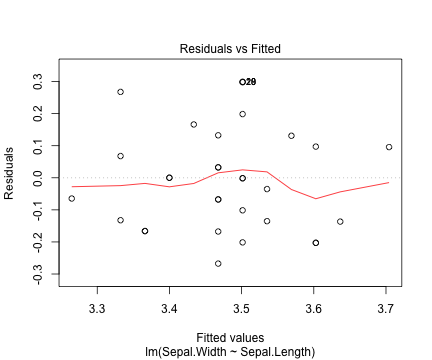

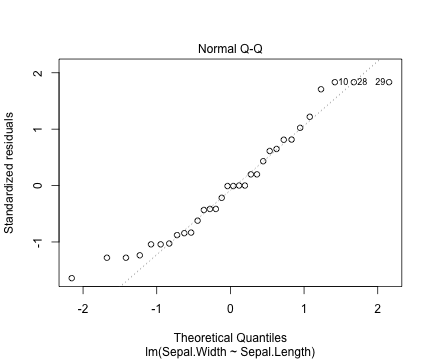

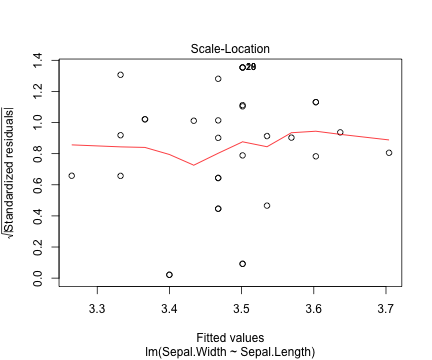

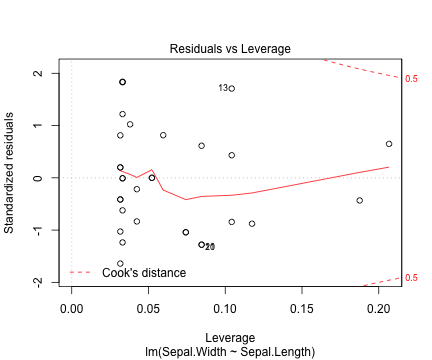

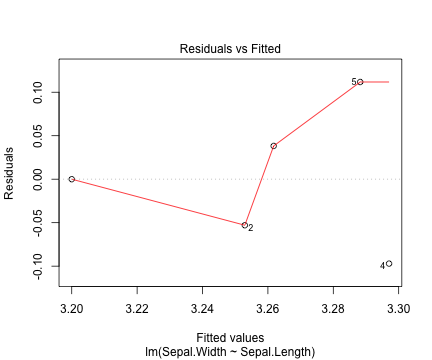

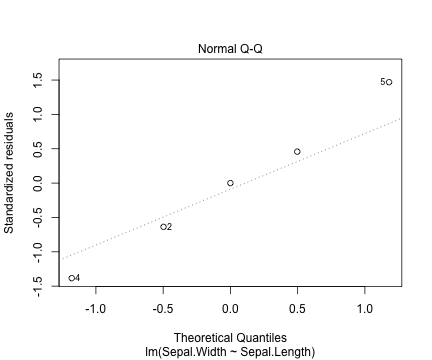

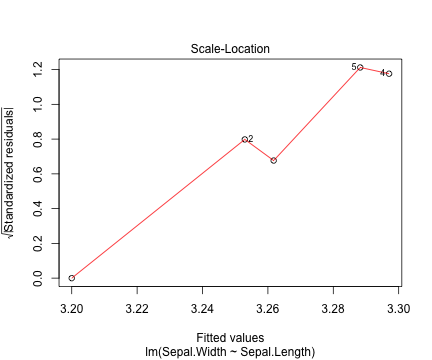

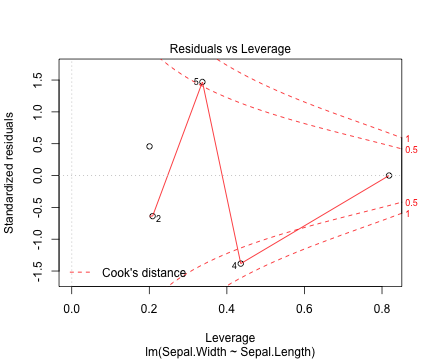

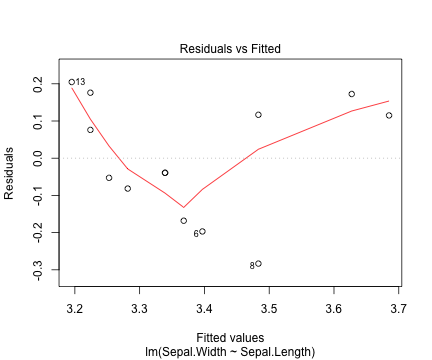

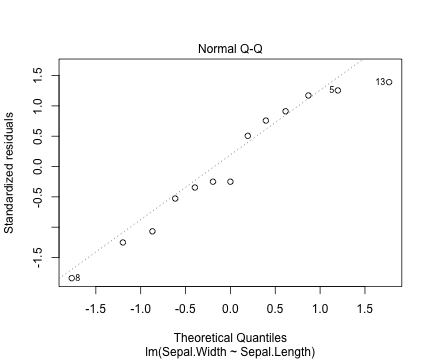

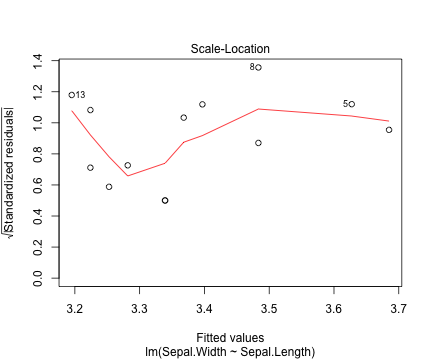

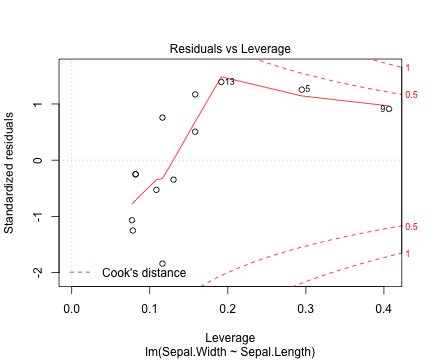

┌ Warning: RCall.jl: ─ Attaching packages ──────────────────── tidyverse 1.2.1 ─
│ ✔ ggplot2 3.2.1           ✔ purrr   0.3.2      
│ ✔ tibble  2.1.3           ✔ dplyr   0.8.3      
│ ✔ tidyr   0.8.99.9000     ✔ stringr 1.4.0      
│ ✔ readr   1.3.1           ✔ forcats 0.4.0      
│ ─ Conflicts ───────────────────── tidyverse_conflicts() ─
│ ✖ dplyr::filter() masks stats::filter()
│ ✖ dplyr::lag()    masks stats::lag()
└ @ RCall /Users/takuizum/.julia/packages/RCall/g7dhB/src/io.jl:113


RObject{VecSxp}
[[1]]

Call:
lm(formula = Sepal.Width ~ Sepal.Length, data = .x)

Coefficients:
 (Intercept)  Sepal.Length  
      1.7768        0.3382  


[[2]]

Call:
lm(formula = Sepal.Width ~ Sepal.Length, data = .x)

Coefficients:
 (Intercept)  Sepal.Length  
     3.81765      -0.08824  


[[3]]

Call:
lm(formula = Sepal.Width ~ Sepal.Length, data = .x)

Coefficients:
 (Intercept)  Sepal.Length  
      1.4086        0.2882  




In [24]:
using RCall
R"""
library(tidyverse)
iris %>% 
    filter(Sepal.Width >= 3.2 & Sepal.Width <= 3.8) %>%
    group_by(Species) %>%
    nest %>%
    mutate(ols = map(data, ~lm(data = .x, formula = Sepal.Width ~ Sepal.Length)), 
           plt = map(ols, ~plot(.x))) %>%
    pull(ols)
"""

**これがやりたい！！！**と思ったのですが，結論として，現在のjuliaでそれは難しかったです。しかしそれでも一部の操作はtidyに実行できるので，その一部を紹介します。

juliaでtidyverse流のデータフレーム操作を円滑に行うためには`DataFramesMeta`か`Query`を使うといいです。`JuliaDB`という選択肢もありますが，DataFramesを介さないので，今回は取り扱いません。`Query`も，また別の機会に扱おうと思います。

----
## `DataFramesMeta`

In [31]:
using DataFramesMeta, Statistics, StatsBase

`DataFramesMeta`はマクロで操作を行います。使えるマクロは以下の通りです。

- `with` データフレームの列の要素をsymbolで参照して，処理をするマクロ。ほかのマクロを動かすための基本的なマクロであるため，ユーザーがデータ整形で使うことは稀かもしれない。
- `where` 特定の列の要素で行ごとに絞り込む。Rでいうfilter関数
- `select` 列の名前で絞り込み＆列の要素に関数をあてて変換を行います。
- `transform` `select`と同様に列の要素を変換するが，`select`とは異なり新たな列を生成します。
- `groupby` 指定した列の要素ごとにデータフレームを分割し，`GroupedDataFrame`と呼ばれる型に変化させます。変換させた以降の処理は，分割したデータフレームごとに処理されます。
- `by` `groupby` + `transform`の処理を一行で実行できます。
- `orderby` `GroupedDataFrame`のまとまりごとに，指定した列の要素でソートをかけます。そんなに使用頻度は高くないかも。
- `based_on` `GroupedDataFrame`のまとまりごとに，関数を適用して要約統計量などを計算します。`length`や`sum`などのベクトルを取る関数が必要になります。

上記のものたちは基本はマクロですが，`@linq`マクロを使うことで，関数のように使用することができます。

- `byrow!` `begin`と`end`ブロックを使って行ごとの操作を実行します。

### `with`の使用例

In [32]:
@linq iris |> with(iris[:SepalLength .> 6., :]) |> first(5)

5×5 DataFrame
│ Row │ SepalLength │ SepalWidth │ PetalLength │ PetalWidth │ Species      │
│     │ Float64     │ Float64    │ Float64     │ Float64    │ Categorical… │
├─────┼─────────────┼────────────┼─────────────┼────────────┼──────────────┤
│ 1   │ 7.0         │ 3.2        │ 4.7         │ 1.4        │ versicolor   │
│ 2   │ 6.4         │ 3.2        │ 4.5         │ 1.5        │ versicolor   │
│ 3   │ 6.9         │ 3.1        │ 4.9         │ 1.5        │ versicolor   │
│ 4   │ 6.5         │ 2.8        │ 4.6         │ 1.5        │ versicolor   │
│ 5   │ 6.3         │ 3.3        │ 4.7         │ 1.6        │ versicolor   │

### `groupby`と`by`の使用例

グルーピングした後に，SepalLengthを標準化してみます。きちんと標準化できているかを最後の行で確認します。

In [35]:
@linq iris |>
   where(5.0 .≥ :SepalWidth .≥ 3.0) |>
   groupby(:Species) |>
   transform(StdSepalLn = zscore(:SepalLength)) |>
   by(:Species, mean = mean(:StdSepalLn), var = std(:StdSepalLn))

3×3 DataFrame
│ Row │ Species      │ mean        │ var     │
│     │ Categorical… │ Float64     │ Float64 │
├─────┼──────────────┼─────────────┼─────────┤
│ 1   │ setosa       │ 2.19211e-15 │ 1.0     │
│ 2   │ versicolor   │ 8.32667e-17 │ 1.0     │
│ 3   │ virginica    │ 2.12091e-15 │ 1.0     │

### `orderby`の使用例

In [36]:
OrderedIris = @linq iris |>
    where(7.0 .≥ :SepalLength) |>
    groupby(:Species) |>
    orderby(:SepalLength)
map(df -> first(df, 3), OrderedIris)

GroupedDataFrame with 3 groups based on key: Species
First Group (3 rows): Species = "setosa". Omitted printing of 1 columns
│ Row │ Species      │ SepalLength │ SepalWidth │ PetalLength │ PetalWidth │
│     │ Categorical… │ Float64     │ Float64    │ Float64     │ Float64    │
├─────┼──────────────┼─────────────┼────────────┼─────────────┼────────────┤
│ 1   │ setosa       │ 5.1         │ 3.5        │ 1.4         │ 0.2        │
│ 2   │ setosa       │ 4.9         │ 3.0        │ 1.4         │ 0.2        │
│ 3   │ setosa       │ 4.7         │ 3.2        │ 1.3         │ 0.2        │
⋮
Last Group (3 rows): Species = "versicolor". Omitted printing of 1 columns
│ Row │ Species      │ SepalLength │ SepalWidth │ PetalLength │ PetalWidth │
│     │ Categorical… │ Float64     │ Float64    │ Float64     │ Float64    │
├─────┼──────────────┼─────────────┼────────────┼─────────────┼────────────┤
│ 1   │ versicolor   │ 7.0         │ 3.2        │ 4.7         │ 1.4        │
│ 2   │ versicolor   │ 6.4         │ 3.2        │ 4.5         │ 1.5        │
│ 3   │ versicolor   │ 6.9         │ 3.1        │ 4.9         │ 1.5        │

### `based_on`の使用例

In [37]:
@linq iris |> groupby(:Species) |> based_on(MEAN = mean(:SepalLength), VAR = var(:SepalLength))

3×3 DataFrame
│ Row │ Species      │ MEAN    │ VAR      │
│     │ Categorical… │ Float64 │ Float64  │
├─────┼──────────────┼─────────┼──────────┤
│ 1   │ setosa       │ 5.006   │ 0.124249 │
│ 2   │ versicolor   │ 5.936   │ 0.266433 │
│ 3   │ virginica    │ 6.588   │ 0.404343 │

関数の返ってくる値の長さが違う場合には，短いものが繰り返されます。この例はMEANは各グループで一つしか計算されませんが，DOUBLEはすべてのレコードで計算されるため，MEANの結果が繰り返されています。

In [39]:
@linq iris |> groupby(:Species) |> based_on(MEAN = mean(:SepalLength), DOUBLE = 2*:SepalLength) |> first(5)

5×3 DataFrame
│ Row │ Species      │ MEAN    │ DOUBLE  │
│     │ Categorical… │ Float64 │ Float64 │
├─────┼──────────────┼─────────┼─────────┤
│ 1   │ setosa       │ 5.006   │ 10.2    │
│ 2   │ setosa       │ 5.006   │ 9.8     │
│ 3   │ setosa       │ 5.006   │ 9.4     │
│ 4   │ setosa       │ 5.006   │ 9.2     │
│ 5   │ setosa       │ 5.006   │ 10.0    │

----
## グループごとの統計処理

`groupby`した要素にアクセスする際は`[Int]`を用います。また，グループごとに同様の関数を適用したいときは`map`を使います。

In [40]:
GroupedIris = @linq iris |> groupby(:Species)
@linq GroupedIris[1] |> first(3)

3×5 DataFrame
│ Row │ SepalLength │ SepalWidth │ PetalLength │ PetalWidth │ Species      │
│     │ Float64     │ Float64    │ Float64     │ Float64    │ Categorical… │
├─────┼─────────────┼────────────┼─────────────┼────────────┼──────────────┤
│ 1   │ 5.1         │ 3.5        │ 1.4         │ 0.2        │ setosa       │
│ 2   │ 4.9         │ 3.0        │ 1.4         │ 0.2        │ setosa       │
│ 3   │ 4.7         │ 3.2        │ 1.3         │ 0.2        │ setosa       │

回帰分析を集団ごとに実行してみましょう。`GLM`パッケージの`lm`でかんたんに実行できます。しかし，回帰分析の推定結果そのものをデータフレームに入れようとするとうまく行かないので，ここでは推定値を取り出す`coef`を使って，回帰係数と切片の値だけ取り出してみます。

In [41]:
using GLM
res = map(x -> coef(lm(@formula(SepalLength ~ SepalWidth), x)), GroupedIris)

GroupedDataFrame with 3 groups based on key: Species
First Group (2 rows): Species = "setosa"
│ Row │ Species      │ x1      │
│     │ Categorical… │ Float64 │
├─────┼──────────────┼─────────┤
│ 1   │ setosa       │ 2.639   │
│ 2   │ setosa       │ 0.69049 │
⋮
Last Group (2 rows): Species = "virginica"
│ Row │ Species      │ x1       │
│     │ Categorical… │ Float64  │
├─────┼──────────────┼──────────┤
│ 1   │ virginica    │ 3.90684  │
│ 2   │ virginica    │ 0.901534 │

同様にグループごとにプロットをすることもできます。

┌ Warning: `getindex(sdf::SubDataFrame, colind::ColumnIndex)` is deprecated, use `sdf[!, colind]` instead.
│   caller = evalmapping at dataframes.jl:96 [inlined]
└ @ Core /Users/takuizum/.julia/packages/Gadfly/09PWZ/src/dataframes.jl:96


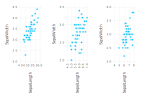

In [42]:
plt = @linq map(df -> plot(df, x="SepalLength", y="SepalWidth", Geom.point), GroupedIris) |> DataFrame
gridstack([plt[1,:x1] plt[2,:x1] plt[3,:x1]])

回帰直線もなんとか引きたい...と頑張ったのですが，ここらへんで力尽きました。